___

In [1]:
import os

def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehData')
    figDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehFigs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

D:\Dropbox\SonicationBehavior\SonBehData


In [2]:
import pandas as pd

def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it

In [4]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

(200, 7)


,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [5]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
    # pad with 0's
    tmp = readMyFile(buzzClass.fileName[ii])
    pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
    zx = np.repeat(0, len(pad))
    pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
    pdff.columns = tmp.columns

    tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [6]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)

In [7]:
df.head()

,0,1,varia,buzz,filename
0,0.000000,0.001246,0.002879,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
1,0.000005,0.001571,0.002876,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
2,0.000010,-0.001999,0.002873,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
3,0.000015,0.002544,0.002871,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
4,0.000020,0.004167,0.002869,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...


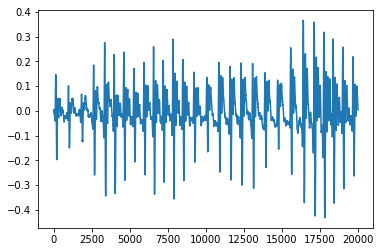

In [8]:
plt.plot(df.iloc[0:20000, 1])

In [9]:
df.shape

(4799800, 5)

In [10]:
from sklearn.preprocessing import MinMaxScaler

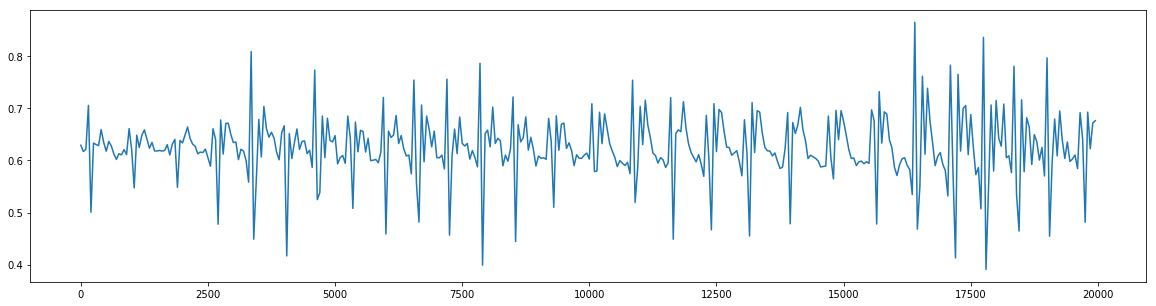

(4799800, 6)

In [11]:
mm = MinMaxScaler((0,1))
mm.fit(df.iloc[:, 1].values.reshape(-1, 1))
df["scaledBuzz"] = mm.transform(df.iloc[:, 1].values.reshape(-1, 1))


subSamp = np.arange(0, 20000, step = 50)# np.arange(0, df.shape[0], step = 5)
plt.figure(figsize=(20,5))
plt.plot(np.array(df.index[subSamp]), np.array(df.iloc[subSamp,5]))
#plt.scatter(df.index[subSamp], df.iloc[subSamp,2]*10, s = 0.5, c = df.iloc[subSamp,3])
plt.show()
df.shape

In [12]:
# downsample dataset
print(df.shape)
subSamp = np.arange(0, df.shape[0], step = 10)# np.arange(0, df.shape[0], step = 5)
df = df.iloc[subSamp, :]
print(df.shape)

(4799800, 6)
(479980, 6)


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
seq = df.loc[:,"scaledBuzz"]

# timesteps = np.linspace(0, 2, num = 2000000)
# freq = ((np.sin(timesteps*timesteps/2*10*2*np.pi) + 1)**3 > 4 ) + 0.3
# seq = np.sin((freq*100 * timesteps) * 2 * np.pi)
# plt.plot(timesteps, seq)
# plt.plot(timesteps, freq + 1)

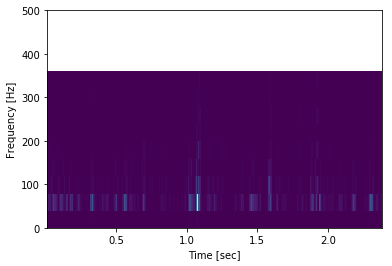

In [15]:
from scipy import signal

f, t, Sxx = signal.spectrogram(np.array(seq), 200000, noverlap = 4000, nperseg = 5000)
Sxx = Sxx[0:10]
f = f[0:10]
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,500)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

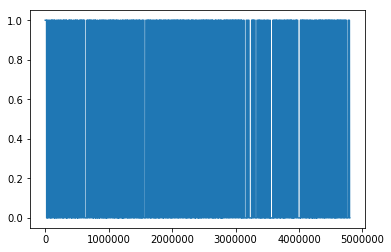

In [16]:
# buzzes = freq > 1.0
buzzes = df.buzz
plt.plot(buzzes[0:1000000])

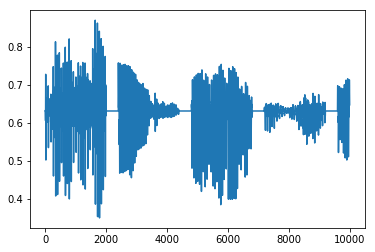

In [17]:
# scale dataset
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(seq).reshape(-1,1))
plt.plot(dataset[0:10000])

In [18]:
# refref: look back should include Y, too...

In [19]:
# create dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 500

trainX, trainY = create_dataset(dataset[0:int(dataset.shape[0]*0.75)], look_back)
testX, testY = create_dataset(dataset[(int(dataset.shape[0]*0.75)+1):], look_back)

print(trainY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



(359484,)


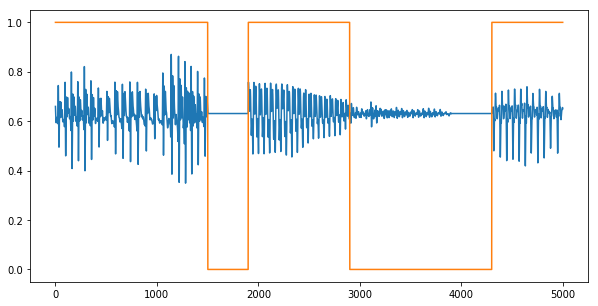

In [20]:
trainX.shape
plt.figure(figsize=[10,5])
plt.plot(trainX[0:5000, 0, -1])

trainY= np.array(buzzes[look_back:(trainX.shape[0]+look_back)])
plt.plot(trainY[0:5000])

# refref: alignment might be off

In [21]:
np.array(testY)

array([0.630776  , 0.63550413, 0.63829803, ..., 0.63102526, 0.63102526,
       0.63102526])

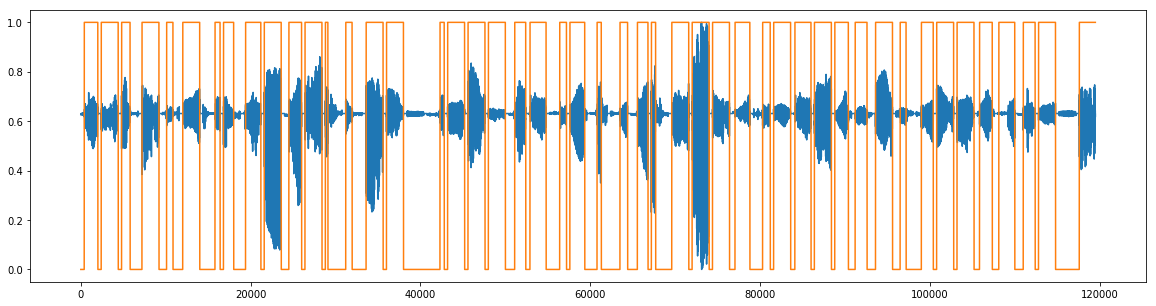

In [22]:
testY=np.array(buzzes[(trainX.shape[0]+look_back):(trainX.shape[0] + look_back + testY.shape[0])])
plt.figure(figsize=[20,5])
plt.plot(testX[0:500000,0,0])
plt.plot(testY[0:500000])

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Bidirectional


earlystop = EarlyStopping(monitor='loss', patience=300, verbose=1, mode='auto', min_delta = 0.0001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)


# refref: add bidirectionality
# create and fit the LSTM network
model = Sequential()
model.add(CuDNNLSTM(512, return_sequences = True, input_shape=(1, look_back)))
model.add((CuDNNLSTM(512, return_sequences = False)))
# refref add more layers, and increase lookback
#model.add(Dense(4, input_shape=(1, trainX.shape[2] )))
model.add((Dense(1, activation = "sigmoid")))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
hitory = model.fit(trainX, trainY, validation_split = 0.1, epochs=200, batch_size=15000, verbose=1, callbacks = [earlystop, reduce_lr])

Train on 323535 samples, validate on 35949 samples
Epoch 1/200
323535/323535 [==============================] - 6s 19us/step - loss: 0.6680 - acc: 0.6128 - val_loss: 0.7425 - val_acc: 0.4590
Epoch 2/200
323535/323535 [==============================] - 4s 11us/step - loss: 0.6677 - acc: 0.6128 - val_loss: 0.7378 - val_acc: 0.4590
Epoch 3/200
323535/323535 [==============================] - 4s 11us/step - loss: 0.6676 - acc: 0.6128 - val_loss: 0.7320 - val_acc: 0.4590
Epoch 4/200
323535/323535 [==============================] - 3s 11us/step - loss: 0.6676 - acc: 0.6128 - val_loss: 0.7297 - val_acc: 0.4590
Epoch 5/200
323535/323535 [==============================] - 4s 11us/step - loss: 0.6676 - acc: 0.6128 - val_loss: 0.7309 - val_acc: 0.4590
Epoch 6/200
323535/323535 [==============================] - 4s 11us/step - loss: 0.6676 - acc: 0.6128 - val_loss: 0.7313 - val_acc: 0.4590
Epoch 7/200
323535/323535 [==============================] - 4s 11us/step - loss: 0.6676 - acc: 0.6128 - val_

In [ ]:
print(model.summary())

In [ ]:
hitory = model.fit(trainX, trainY, validation_split = 0.1, epochs=10, batch_size=150000, verbose=1, callbacks = [earlystop, reduce_lr])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


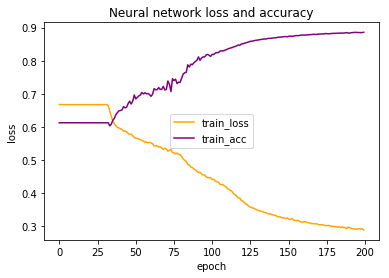

In [25]:
print(hitory.history.keys())


plt.plot(hitory.history['loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(hitory.history['acc'], c = "purple")
plt.legend(['train_loss', 'train_acc'], loc='center')


plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


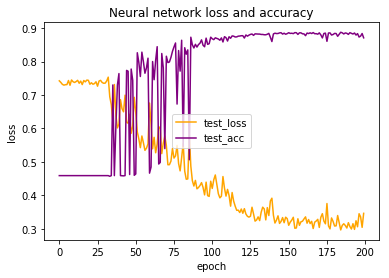

In [26]:
print(hitory.history.keys())


plt.plot(hitory.history['val_loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(hitory.history['val_acc'], c = "purple")
plt.legend(['test_loss', 'test_acc'], loc='center')


plt.show()

In [ ]:
os.getcwd()

In [27]:
# save model
from keras.models import load_model

model.save('C:\\Users\\calli\\Desktop\\my_model_2.h5')  # creates a HDF5 file 'my_model.h5'


# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [28]:
trainY = trainY.reshape(-1)
testY = testY.reshape(-1)

# make predictions
trainPredict = model.predict_classes(trainX)
testPredict = model.predict_classes(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# plot
# plt.figure(figsize = [10, 5])
# plt.plot(trainPredict, c="orange")
# plt.plot(trainY[0,:])

# plt.show()

# plt.plot(testY[0,0:50000])
# plt.plot(testPredict[0:50000], c= 'orange')

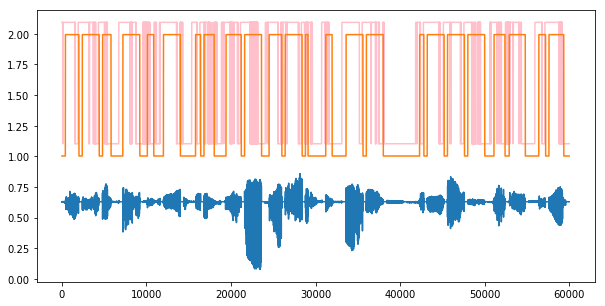

In [29]:
plt.figure(figsize = [10, 5])
plt.plot(testX[0:60000,0, 0])
plt.plot(testPredict[0:60000] + 1.1, c= 'pink')
plt.plot(testY[0,0:60000] + 1)

In [30]:
# merge 1's
# exclude short sequences
cc = (testPredict[0:60000] > 0.5)
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 0) ,0] = True
lengths[(lengths[:,1]>=700) & (lengths[:,0] == 0),0] = False

lengths[:,0]
lengths[:,1].astype(int)
keepers = np.repeat(lengths[:,0], lengths[:,1].astype(int))


cc = keepers
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 1) ,0] = False
keepers2 = np.repeat(lengths[:,0], lengths[:,1].astype(int))


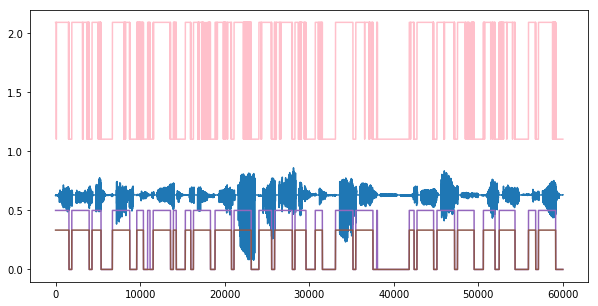

In [31]:
plt.figure(figsize = [10, 5])



plt.plot(testX[0:60000,0, 0])
plt.plot(testPredict[0:60000] + 1.1, c= 'pink')
plt.plot(testY[0:60000] + 1)
plt.plot(keepers / 2)

plt.plot(keepers2 / 3)


In [32]:
# calculate accuracy on whole test set
# exclude short sequences
cc = (testPredict > 0.5)
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 0) ,0] = True
lengths[(lengths[:,1]>=700) & (lengths[:,0] == 0),0] = False

lengths[:,0]
lengths[:,1].astype(int)
keepers = np.repeat(lengths[:,0], lengths[:,1].astype(int))


cc = keepers
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 1) ,0] = False
keepers2 = np.repeat(lengths[:,0], lengths[:,1].astype(int))


In [33]:
from sklearn.metrics import accuracy_score

In [34]:
((testY > 0.5)*1.0).astype(int)[0,:]

array([0, 0, 0, ..., 1, 1, 1])

In [35]:
accuracy_score(((testY > 0.5)*1.0).astype(int)[0,:], keepers2.astype(int))

0.6687169959746596

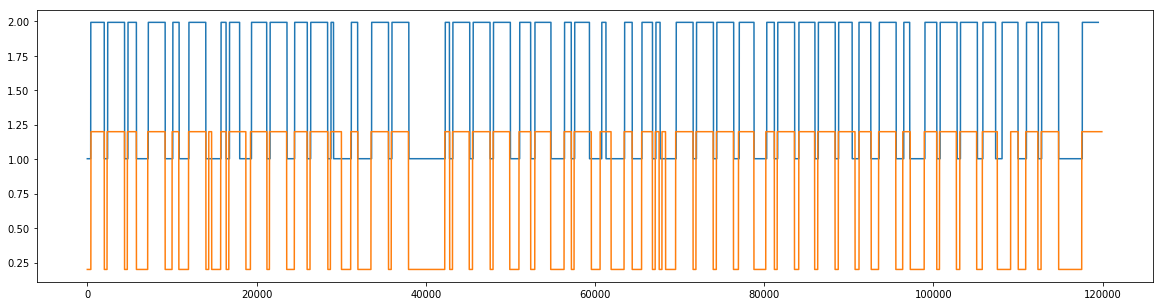

In [59]:
plt.figure(figsize = [20, 5])
plt.plot(testY[0,0:] + 1)
#plt.plot(keepers2.astype(int))
k2 = np.hstack([np.zeros(420), keepers2])
plt.plot(k2 + 0.2)

In [63]:
for jj in np.arange(400, 550, step = 10):
    k2 = np.hstack([np.zeros(jj), keepers2])
    asc = accuracy_score(((testY > 0.5)*1.0).astype(int)[0,:], k2[0:testY.shape[1]].astype(int))
    print(asc, jj)

0.9124634915852812 400
0.9178696660055401 410
0.9226398199057685 420
0.9264224682617391 430
0.9287991765208004 440
0.93075745022721 450
0.9319290669746345 460
0.9313934707472404 470
0.9299540558861189 480
0.927677771919694 490
0.9232925778079051 500
0.9169825847539187 510
0.9098691973588411 520
0.9027558099637636 530
0.8954750487476254 540


In [49]:
testY.shape

(1, 119493)